In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
l2Regularizer=1e-09
kernel_size1 = 3
kernel_size2 = 5
kernel_size3 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [19]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [13]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [14]:
image_np = image_df.iloc[:, :].values

In [15]:
image = image_np.reshape((133, 16, 100, 100))

In [20]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [21]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [22]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [23]:
y = y.reshape((133, 16, 2, 1))

In [24]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [25]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [26]:
geometry.shape

(2128, 1)

In [27]:
geometry = geometry.reshape((133, 16, 1))

In [28]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.3, random_state=1)

In [29]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [34]:
x_train.shape

(1488, 100, 100, 1)

In [31]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size2, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer2')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size3, kernel_size3), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer3')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 50, 50, 25)        250       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 25)       0         
 2D)                                                             
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 13, 13, 25)        15650     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 25)         0         
 2D)                                                             
                                                                 
 Conv2DLayer3 (Conv2D)       (None, 3, 3, 25)          15650 

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 5s 13ms/step - loss: 0.0665 - rmse: 0.2580
Epoch 2/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0120 - rmse: 0.1095
Epoch 3/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0117 - rmse: 0.1081
Epoch 4/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0086 - rmse: 0.0929
Epoch 5/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0079 - rmse: 0.0888
Epoch 6/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0078 - rmse: 0.0884
Epoch 7/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0078 - rmse: 0.0886
Epoch 8/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0088 - rmse: 0.0941
Epoch 9/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0072 - rmse: 0.0849
Epoch 10/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0061 - rmse: 0.0780
Epoch 11/5000
47/47 [=================

47/47 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0587
Epoch 86/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0029 - rmse: 0.0540
Epoch 87/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0030 - rmse: 0.0550
Epoch 88/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0034 - rmse: 0.0584
Epoch 89/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0034 - rmse: 0.0586
Epoch 90/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0588
Epoch 91/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0557
Epoch 92/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0552
Epoch 93/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0595
Epoch 94/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0591
Epoch 95/5000
47/47 [=======================

47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0408
Epoch 169/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0017 - rmse: 0.0413
Epoch 170/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0413
Epoch 171/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0019 - rmse: 0.0438
Epoch 172/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0019 - rmse: 0.0431
Epoch 173/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0402
Epoch 174/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0384
Epoch 175/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0016 - rmse: 0.0399
Epoch 176/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0404
Epoch 177/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0401
Epoch 178/5000
47/47 [=============

Epoch 251/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0332
Epoch 252/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0339
Epoch 253/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0010 - rmse: 0.0318
Epoch 254/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0350
Epoch 255/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0401
Epoch 256/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0353
Epoch 257/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0010 - rmse: 0.0323
Epoch 258/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8282e-04 - rmse: 0.0280
Epoch 259/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.7097e-04 - rmse: 0.0312
Epoch 260/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0344
Epoch 261/50

47/47 [==============================] - 0s 6ms/step - loss: 8.4381e-04 - rmse: 0.0290
Epoch 333/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.9825e-04 - rmse: 0.0244
Epoch 334/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.4809e-04 - rmse: 0.0234
Epoch 335/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1037e-04 - rmse: 0.0247
Epoch 336/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.6222e-04 - rmse: 0.0237
Epoch 337/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.4129e-04 - rmse: 0.0210
Epoch 338/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.8358e-04 - rmse: 0.0196
Epoch 339/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.9813e-04 - rmse: 0.0223
Epoch 340/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.9864e-04 - rmse: 0.0245
Epoch 341/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.5603e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 0.0027 - rmse: 0.0523
Epoch 413/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0029 - rmse: 0.0539
Epoch 414/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0495
Epoch 415/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0017 - rmse: 0.0410
Epoch 416/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0349
Epoch 417/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.2691e-04 - rmse: 0.0287
Epoch 418/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2910e-04 - rmse: 0.0251
Epoch 419/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.8586e-04 - rmse: 0.0242
Epoch 420/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.5123e-04 - rmse: 0.0212
Epoch 421/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.6464e-04 - rmse: 0.0191
Epoch 422/5000


Epoch 493/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.9277e-04 - rmse: 0.0198
Epoch 494/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.6676e-04 - rmse: 0.0191
Epoch 495/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.4991e-04 - rmse: 0.0187
Epoch 496/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.6986e-04 - rmse: 0.0192
Epoch 497/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.1637e-04 - rmse: 0.0204
Epoch 498/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.0626e-04 - rmse: 0.0175
Epoch 499/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.1113e-04 - rmse: 0.0176
Epoch 500/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8708e-04 - rmse: 0.0169
Epoch 501/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.7716e-04 - rmse: 0.0166
Epoch 502/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.5868

47/47 [==============================] - 0s 8ms/step - loss: 6.1569e-04 - rmse: 0.0248
Epoch 574/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.7641e-04 - rmse: 0.0240
Epoch 575/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.6492e-04 - rmse: 0.0238
Epoch 576/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.4049e-04 - rmse: 0.0232
Epoch 577/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.2849e-04 - rmse: 0.0230
Epoch 578/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.3273e-04 - rmse: 0.0208
Epoch 579/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.3531e-04 - rmse: 0.0208
Epoch 580/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.6366e-04 - rmse: 0.0191
Epoch 581/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.2992e-04 - rmse: 0.0181
Epoch 582/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7331e-04 - rmse: 0.

47/47 [==============================] - 0s 7ms/step - loss: 2.2154e-04 - rmse: 0.0149
Epoch 654/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0147e-04 - rmse: 0.0142
Epoch 655/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7759e-04 - rmse: 0.0133
Epoch 656/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8893e-04 - rmse: 0.0137
Epoch 657/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9746e-04 - rmse: 0.0140
Epoch 658/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1795e-04 - rmse: 0.0147
Epoch 659/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7344e-04 - rmse: 0.0165
Epoch 660/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1018e-04 - rmse: 0.0145
Epoch 661/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7540e-04 - rmse: 0.0132
Epoch 662/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8948e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 1.7153e-04 - rmse: 0.0131
Epoch 734/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8196e-04 - rmse: 0.0135
Epoch 735/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5645e-04 - rmse: 0.0125
Epoch 736/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9221e-04 - rmse: 0.0138
Epoch 737/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0439e-04 - rmse: 0.0143
Epoch 738/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8201e-04 - rmse: 0.0135
Epoch 739/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6860e-04 - rmse: 0.0130
Epoch 740/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7465e-04 - rmse: 0.0132
Epoch 741/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2920e-04 - rmse: 0.0151
Epoch 742/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3425e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 2.6053e-04 - rmse: 0.0161
Epoch 814/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.9284e-04 - rmse: 0.0171
Epoch 815/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6257e-04 - rmse: 0.0162
Epoch 816/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9323e-04 - rmse: 0.0139
Epoch 817/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3502e-04 - rmse: 0.0153
Epoch 818/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6221e-04 - rmse: 0.0162
Epoch 819/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7258e-04 - rmse: 0.0165
Epoch 820/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3460e-04 - rmse: 0.0153
Epoch 821/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3111e-04 - rmse: 0.0152
Epoch 822/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.4486e-04 - rmse: 0.

47/47 [==============================] - 0s 7ms/step - loss: 1.6632e-04 - rmse: 0.0129
Epoch 894/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4071e-04 - rmse: 0.0118
Epoch 895/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9910e-04 - rmse: 0.0141
Epoch 896/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7637e-04 - rmse: 0.0132
Epoch 897/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5835e-04 - rmse: 0.0125
Epoch 898/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4601e-04 - rmse: 0.0120
Epoch 899/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8750e-04 - rmse: 0.0137
Epoch 900/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8357e-04 - rmse: 0.0135
Epoch 901/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9450e-04 - rmse: 0.0139
Epoch 902/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3433e-04 - rmse: 0.

47/47 [==============================] - 0s 7ms/step - loss: 2.0466e-04 - rmse: 0.0143
Epoch 974/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0287e-04 - rmse: 0.0142
Epoch 975/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.4456e-04 - rmse: 0.0185
Epoch 976/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2832e-04 - rmse: 0.0151
Epoch 977/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9950e-04 - rmse: 0.0141
Epoch 978/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9234e-04 - rmse: 0.0138
Epoch 979/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7546e-04 - rmse: 0.0132
Epoch 980/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7176e-04 - rmse: 0.0131
Epoch 981/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6705e-04 - rmse: 0.0129
Epoch 982/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6316e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 1.2376e-04 - rmse: 0.0111
Epoch 1054/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4091e-04 - rmse: 0.0118
Epoch 1055/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2253e-04 - rmse: 0.0110
Epoch 1056/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4611e-04 - rmse: 0.0120
Epoch 1057/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1793e-04 - rmse: 0.0147
Epoch 1058/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7858e-04 - rmse: 0.0133
Epoch 1059/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9375e-04 - rmse: 0.0139
Epoch 1060/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6465e-04 - rmse: 0.0128
Epoch 1061/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5042e-04 - rmse: 0.0122
Epoch 1062/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5991e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.7688e-04 - rmse: 0.0133
Epoch 1133/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9291e-04 - rmse: 0.0138
Epoch 1134/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6794e-04 - rmse: 0.0129
Epoch 1135/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7665e-04 - rmse: 0.0132
Epoch 1136/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.9170e-04 - rmse: 0.0138
Epoch 1137/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7048e-04 - rmse: 0.0130
Epoch 1138/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9555e-04 - rmse: 0.0139
Epoch 1139/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1520e-04 - rmse: 0.0146
Epoch 1140/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1589e-04 - rmse: 0.0147
Epoch 1141/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.8346e-04 -

Epoch 1212/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3509e-04 - rmse: 0.0116
Epoch 1213/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2258e-04 - rmse: 0.0110
Epoch 1214/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.4118e-04 - rmse: 0.0118
Epoch 1215/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5330e-04 - rmse: 0.0123
Epoch 1216/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7856e-04 - rmse: 0.0133
Epoch 1217/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3288e-04 - rmse: 0.0152
Epoch 1218/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7190e-04 - rmse: 0.0131
Epoch 1219/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6519e-04 - rmse: 0.0128
Epoch 1220/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8124e-04 - rmse: 0.0134
Epoch 1221/5000
47/47 [==============================] - 0s 7ms/step - lo

47/47 [==============================] - 0s 6ms/step - loss: 2.1328e-04 - rmse: 0.0146
Epoch 1292/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6729e-04 - rmse: 0.0129
Epoch 1293/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4749e-04 - rmse: 0.0121
Epoch 1294/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9812e-04 - rmse: 0.0140
Epoch 1295/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7215e-04 - rmse: 0.0131
Epoch 1296/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5319e-04 - rmse: 0.0123
Epoch 1297/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7455e-04 - rmse: 0.0132
Epoch 1298/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2623e-04 - rmse: 0.0112
Epoch 1299/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2032e-04 - rmse: 0.0109
Epoch 1300/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2872e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 1371/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.3683e-04 - rmse: 0.0252
Epoch 1372/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.8862e-04 - rmse: 0.0197
Epoch 1373/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5187e-04 - rmse: 0.0158
Epoch 1374/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3105e-04 - rmse: 0.0152
Epoch 1375/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4923e-04 - rmse: 0.0122
Epoch 1376/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3542e-04 - rmse: 0.0116
Epoch 1377/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6651e-04 - rmse: 0.0129
Epoch 1378/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.1457e-04 - rmse: 0.0146
Epoch 1379/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7823e-04 - rms

47/47 [==============================] - 0s 8ms/step - loss: 9.0732e-04 - rmse: 0.0301
Epoch 1450/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 1451/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0392
Epoch 1452/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0373
Epoch 1453/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0336
Epoch 1454/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2250e-04 - rmse: 0.0287
Epoch 1455/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3423e-04 - rmse: 0.0252
Epoch 1456/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.4163e-04 - rmse: 0.0210
Epoch 1457/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.1989e-04 - rmse: 0.0178
Epoch 1458/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2960e-04 - rmse: 0.0151
Ep

47/47 [==============================] - 0s 8ms/step - loss: 1.2604e-04 - rmse: 0.0112
Epoch 1529/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1175e-04 - rmse: 0.0105
Epoch 1530/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0127e-04 - rmse: 0.0100
Epoch 1531/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0411e-04 - rmse: 0.0101
Epoch 1532/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2416e-04 - rmse: 0.0111
Epoch 1533/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3732e-04 - rmse: 0.0117
Epoch 1534/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8309e-04 - rmse: 0.0135
Epoch 1535/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8277e-04 - rmse: 0.0135
Epoch 1536/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2532e-04 - rmse: 0.0111
Epoch 1537/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2465e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.3267e-04 - rmse: 0.0115
Epoch 1608/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3458e-04 - rmse: 0.0153
Epoch 1609/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3314e-04 - rmse: 0.0152
Epoch 1610/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9187e-04 - rmse: 0.0170
Epoch 1611/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6327e-04 - rmse: 0.0162
Epoch 1612/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2199e-04 - rmse: 0.0148
Epoch 1613/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6310e-04 - rmse: 0.0127
Epoch 1614/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5250e-04 - rmse: 0.0123
Epoch 1615/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8428e-04 - rmse: 0.0135
Epoch 1616/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7554e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 9.9542e-04 - rmse: 0.0315
Epoch 1687/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0487e-04 - rmse: 0.0265
Epoch 1688/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.2397e-04 - rmse: 0.0206
Epoch 1689/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.3900e-04 - rmse: 0.0184
Epoch 1690/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6166e-04 - rmse: 0.0161
Epoch 1691/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6049e-04 - rmse: 0.0126
Epoch 1692/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4595e-04 - rmse: 0.0120
Epoch 1693/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7760e-04 - rmse: 0.0133
Epoch 1694/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2222e-04 - rmse: 0.0110
Epoch 1695/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0669e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.8796e-04 - rmse: 0.0137
Epoch 1766/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7617e-04 - rmse: 0.0132
Epoch 1767/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3129e-04 - rmse: 0.0114
Epoch 1768/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7661e-04 - rmse: 0.0132
Epoch 1769/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7117e-04 - rmse: 0.0130
Epoch 1770/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6174e-04 - rmse: 0.0127
Epoch 1771/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.4880e-04 - rmse: 0.0186
Epoch 1772/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6277e-04 - rmse: 0.0162
Epoch 1773/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9251e-04 - rmse: 0.0138
Epoch 1774/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8390e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 7.9351e-05 - rmse: 0.0088
Epoch 1845/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.7586e-05 - rmse: 0.0093
Epoch 1846/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.9162e-05 - rmse: 0.0099
Epoch 1847/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1894e-04 - rmse: 0.0108
Epoch 1848/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0658e-04 - rmse: 0.0102
Epoch 1849/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.2730e-04 - rmse: 0.0112
Epoch 1850/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7346e-04 - rmse: 0.0131
Epoch 1851/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.6320e-04 - rmse: 0.0190
Epoch 1852/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.8910e-04 - rmse: 0.0197
Epoch 1853/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.3346e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 7.4552e-05 - rmse: 0.0085
Epoch 1924/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1981e-05 - rmse: 0.0084
Epoch 1925/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9401e-05 - rmse: 0.0082
Epoch 1926/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1805e-05 - rmse: 0.0084
Epoch 1927/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9128e-05 - rmse: 0.0082
Epoch 1928/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8818e-05 - rmse: 0.0082
Epoch 1929/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.7551e-05 - rmse: 0.0081
Epoch 1930/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1213e-05 - rmse: 0.0083
Epoch 1931/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6315e-05 - rmse: 0.0080
Epoch 1932/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6266e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.0426e-05 - rmse: 0.0083
Epoch 2003/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.9798e-05 - rmse: 0.0083
Epoch 2004/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9053e-05 - rmse: 0.0082
Epoch 2005/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.9382e-05 - rmse: 0.0088
Epoch 2006/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3376e-05 - rmse: 0.0085
Epoch 2007/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.9362e-05 - rmse: 0.0088
Epoch 2008/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5072e-05 - rmse: 0.0091
Epoch 2009/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.7574e-05 - rmse: 0.0093
Epoch 2010/5000
47/47 [==============================] - 0s 9ms/step - loss: 8.7510e-05 - rmse: 0.0093
Epoch 2011/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1127e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.4956e-04 - rmse: 0.0122
Epoch 2082/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4699e-04 - rmse: 0.0121
Epoch 2083/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.1239e-04 - rmse: 0.0145
Epoch 2084/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8010e-04 - rmse: 0.0134
Epoch 2085/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3327e-04 - rmse: 0.0115
Epoch 2086/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0647e-04 - rmse: 0.0102
Epoch 2087/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.0682e-05 - rmse: 0.0094
Epoch 2088/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3613e-05 - rmse: 0.0096
Epoch 2089/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.1041e-05 - rmse: 0.0095
Epoch 2090/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5053e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 6.7242e-05 - rmse: 0.0081
Epoch 2161/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9383e-05 - rmse: 0.0082
Epoch 2162/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6591e-05 - rmse: 0.0087
Epoch 2163/5000
47/47 [==============================] - 0s 9ms/step - loss: 7.5879e-05 - rmse: 0.0086
Epoch 2164/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8327e-05 - rmse: 0.0082
Epoch 2165/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5031e-04 - rmse: 0.0122
Epoch 2166/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.9415e-04 - rmse: 0.0198
Epoch 2167/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3692e-04 - rmse: 0.0271
Epoch 2168/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1411e-04 - rmse: 0.0267
Epoch 2169/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.0308e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 2.4213e-04 - rmse: 0.0155
Epoch 2240/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7443e-04 - rmse: 0.0131
Epoch 2241/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4284e-04 - rmse: 0.0119
Epoch 2242/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.2117e-04 - rmse: 0.0148
Epoch 2243/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.6330e-04 - rmse: 0.0127
Epoch 2244/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2540e-04 - rmse: 0.0111
Epoch 2245/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0810e-04 - rmse: 0.0103
Epoch 2246/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.2601e-05 - rmse: 0.0095
Epoch 2247/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.6060e-05 - rmse: 0.0092
Epoch 2248/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9365e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 8.3657e-05 - rmse: 0.0090
Epoch 2319/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.3336e-05 - rmse: 0.0090
Epoch 2320/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0132e-04 - rmse: 0.0100
Epoch 2321/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.1817e-05 - rmse: 0.0095
Epoch 2322/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1938e-05 - rmse: 0.0084
Epoch 2323/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.0120e-05 - rmse: 0.0083
Epoch 2324/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.6553e-05 - rmse: 0.0080
Epoch 2325/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1129e-05 - rmse: 0.0077
Epoch 2326/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0301e-05 - rmse: 0.0083
Epoch 2327/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8815e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 8.3072e-05 - rmse: 0.0090
Epoch 2398/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6471e-05 - rmse: 0.0086
Epoch 2399/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.9578e-05 - rmse: 0.0088
Epoch 2400/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.9470e-05 - rmse: 0.0088
Epoch 2401/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.4752e-05 - rmse: 0.0085
Epoch 2402/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9415e-05 - rmse: 0.0082
Epoch 2403/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.6474e-05 - rmse: 0.0086
Epoch 2404/5000
47/47 [==============================] - 0s 9ms/step - loss: 7.1733e-05 - rmse: 0.0084
Epoch 2405/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3366e-05 - rmse: 0.0085
Epoch 2406/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3615e-05 -

47/47 [==============================] - 0s 9ms/step - loss: 8.6350e-05 - rmse: 0.0092
Epoch 2477/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.2475e-05 - rmse: 0.0090
Epoch 2478/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7246e-05 - rmse: 0.0087
Epoch 2479/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1844e-05 - rmse: 0.0084
Epoch 2480/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5653e-05 - rmse: 0.0086
Epoch 2481/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0694e-05 - rmse: 0.0089
Epoch 2482/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.2332e-05 - rmse: 0.0095
Epoch 2483/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1994e-04 - rmse: 0.0109
Epoch 2484/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5896e-04 - rmse: 0.0125
Epoch 2485/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1929e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.0391e-04 - rmse: 0.0101
Epoch 2556/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0666e-04 - rmse: 0.0102
Epoch 2557/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1218e-04 - rmse: 0.0105
Epoch 2558/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1014e-04 - rmse: 0.0104
Epoch 2559/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1671e-04 - rmse: 0.0107
Epoch 2560/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3790e-05 - rmse: 0.0096
Epoch 2561/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.8442e-05 - rmse: 0.0098
Epoch 2562/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.7083e-04 - rmse: 0.0239
Epoch 2563/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.6902e-04 - rmse: 0.0311
Epoch 2564/5000
47/47 [==============================] - 0s 9ms/step - loss: 9.6612e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 3.9235e-04 - rmse: 0.0198
Epoch 2635/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.0158e-04 - rmse: 0.0224
Epoch 2636/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.8428e-04 - rmse: 0.0196
Epoch 2637/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8000e-04 - rmse: 0.0167
Epoch 2638/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2996e-04 - rmse: 0.0151
Epoch 2639/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7895e-04 - rmse: 0.0133
Epoch 2640/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5129e-04 - rmse: 0.0122
Epoch 2641/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8784e-04 - rmse: 0.0136
Epoch 2642/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4217e-04 - rmse: 0.0118
Epoch 2643/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7970e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 9.5903e-04 - rmse: 0.0309
Epoch 2714/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.4585e-04 - rmse: 0.0273
Epoch 2715/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7192e-04 - rmse: 0.0277
Epoch 2716/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.3913e-04 - rmse: 0.0209
Epoch 2717/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.6831e-04 - rmse: 0.0163
Epoch 2718/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6418e-04 - rmse: 0.0127
Epoch 2719/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1585e-04 - rmse: 0.0107
Epoch 2720/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.8517e-05 - rmse: 0.0098
Epoch 2721/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6303e-04 - rmse: 0.0127
Epoch 2722/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1379e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.4920e-04 - rmse: 0.0121
Epoch 2793/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.9332e-05 - rmse: 0.0099
Epoch 2794/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2762e-04 - rmse: 0.0112
Epoch 2795/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1280e-04 - rmse: 0.0105
Epoch 2796/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.8436e-05 - rmse: 0.0098
Epoch 2797/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.4098e-05 - rmse: 0.0091
Epoch 2798/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.9431e-05 - rmse: 0.0088
Epoch 2799/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9867e-05 - rmse: 0.0082
Epoch 2800/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6801e-05 - rmse: 0.0081
Epoch 2801/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5422e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 7.0906e-05 - rmse: 0.0083
Epoch 2872/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1422e-05 - rmse: 0.0083
Epoch 2873/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6176e-05 - rmse: 0.0080
Epoch 2874/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2885e-05 - rmse: 0.0084
Epoch 2875/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0750e-05 - rmse: 0.0089
Epoch 2876/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7880e-05 - rmse: 0.0087
Epoch 2877/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.1412e-05 - rmse: 0.0089
Epoch 2878/5000
47/47 [==============================] - 0s 9ms/step - loss: 7.6391e-05 - rmse: 0.0086
Epoch 2879/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5582e-05 - rmse: 0.0086
Epoch 2880/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7890e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 6.7596e-05 - rmse: 0.0081
Epoch 2951/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.6095e-05 - rmse: 0.0080
Epoch 2952/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5175e-05 - rmse: 0.0086
Epoch 2953/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7583e-05 - rmse: 0.0081
Epoch 2954/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7021e-05 - rmse: 0.0081
Epoch 2955/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2147e-05 - rmse: 0.0084
Epoch 2956/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5052e-05 - rmse: 0.0085
Epoch 2957/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.1551e-05 - rmse: 0.0077
Epoch 2958/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.8915e-05 - rmse: 0.0075
Epoch 2959/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4438e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 6.8561e-05 - rmse: 0.0082
Epoch 3030/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.9554e-05 - rmse: 0.0076
Epoch 3031/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.7552e-05 - rmse: 0.0081
Epoch 3032/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9579e-05 - rmse: 0.0082
Epoch 3033/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1889e-05 - rmse: 0.0084
Epoch 3034/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0521e-05 - rmse: 0.0089
Epoch 3035/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9911e-05 - rmse: 0.0082
Epoch 3036/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8277e-05 - rmse: 0.0087
Epoch 3037/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8966e-05 - rmse: 0.0088
Epoch 3038/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.9897e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 5.9815e-05 - rmse: 0.0076
Epoch 3109/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1700e-05 - rmse: 0.0077
Epoch 3110/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.9032e-05 - rmse: 0.0075
Epoch 3111/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.8458e-05 - rmse: 0.0075
Epoch 3112/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.0838e-05 - rmse: 0.0077
Epoch 3113/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1723e-05 - rmse: 0.0077
Epoch 3114/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.0600e-05 - rmse: 0.0077
Epoch 3115/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1290e-05 - rmse: 0.0083
Epoch 3116/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5950e-05 - rmse: 0.0080
Epoch 3117/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7007e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.0017e-05 - rmse: 0.0082
Epoch 3188/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8823e-05 - rmse: 0.0082
Epoch 3189/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4332e-05 - rmse: 0.0079
Epoch 3190/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8249e-05 - rmse: 0.0081
Epoch 3191/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3493e-05 - rmse: 0.0078
Epoch 3192/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.6500e-05 - rmse: 0.0080
Epoch 3193/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6120e-05 - rmse: 0.0080
Epoch 3194/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2040e-05 - rmse: 0.0077
Epoch 3195/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6256e-05 - rmse: 0.0080
Epoch 3196/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7720e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 6.8787e-05 - rmse: 0.0082
Epoch 3267/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6294e-05 - rmse: 0.0080
Epoch 3268/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1558e-05 - rmse: 0.0083
Epoch 3269/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7836e-05 - rmse: 0.0081
Epoch 3270/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2077e-05 - rmse: 0.0077
Epoch 3271/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2275e-05 - rmse: 0.0078
Epoch 3272/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.7895e-05 - rmse: 0.0081
Epoch 3273/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2988e-05 - rmse: 0.0084
Epoch 3274/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8809e-05 - rmse: 0.0082
Epoch 3275/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.1207e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 1.1546e-04 - rmse: 0.0106
Epoch 3346/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9835e-04 - rmse: 0.0172
Epoch 3347/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8175e-04 - rmse: 0.0167
Epoch 3348/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2896e-04 - rmse: 0.0151
Epoch 3349/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8318e-04 - rmse: 0.0135
Epoch 3350/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6983e-04 - rmse: 0.0164
Epoch 3351/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1720e-04 - rmse: 0.0147
Epoch 3352/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.6491e-04 - rmse: 0.0128
Epoch 3353/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3336e-04 - rmse: 0.0115
Epoch 3354/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.9450e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 6.1925e-05 - rmse: 0.0077
Epoch 3425/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4004e-05 - rmse: 0.0079
Epoch 3426/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2133e-05 - rmse: 0.0084
Epoch 3427/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6180e-05 - rmse: 0.0080
Epoch 3428/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7932e-05 - rmse: 0.0081
Epoch 3429/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4678e-05 - rmse: 0.0079
Epoch 3430/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5243e-05 - rmse: 0.0079
Epoch 3431/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.1574e-05 - rmse: 0.0077
Epoch 3432/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3162e-05 - rmse: 0.0078
Epoch 3433/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3899e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.1015e-05 - rmse: 0.0083
Epoch 3504/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2282e-05 - rmse: 0.0078
Epoch 3505/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.3555e-05 - rmse: 0.0078
Epoch 3506/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3923e-05 - rmse: 0.0079
Epoch 3507/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.0172e-05 - rmse: 0.0076
Epoch 3508/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.0634e-05 - rmse: 0.0076
Epoch 3509/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1333e-05 - rmse: 0.0077
Epoch 3510/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.8750e-05 - rmse: 0.0075
Epoch 3511/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6801e-05 - rmse: 0.0080
Epoch 3512/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5138e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 1.2593e-04 - rmse: 0.0111
Epoch 3583/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2897e-04 - rmse: 0.0113
Epoch 3584/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1559e-04 - rmse: 0.0106
Epoch 3585/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2381e-04 - rmse: 0.0110
Epoch 3586/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.0810e-04 - rmse: 0.0103
Epoch 3587/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.8711e-05 - rmse: 0.0098
Epoch 3588/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.6286e-05 - rmse: 0.0097
Epoch 3589/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.6006e-05 - rmse: 0.0092
Epoch 3590/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4200e-04 - rmse: 0.0118
Epoch 3591/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1946e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 6.1036e-05 - rmse: 0.0077
Epoch 3662/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.2022e-05 - rmse: 0.0084
Epoch 3663/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.9311e-05 - rmse: 0.0082
Epoch 3664/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.8669e-05 - rmse: 0.0082
Epoch 3665/5000
47/47 [==============================] - 0s 9ms/step - loss: 7.5255e-05 - rmse: 0.0085
Epoch 3666/5000
47/47 [==============================] - 0s 10ms/step - loss: 8.7155e-05 - rmse: 0.0092
Epoch 3667/5000
47/47 [==============================] - 1s 11ms/step - loss: 7.4719e-05 - rmse: 0.0085
Epoch 3668/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.7796e-05 - rmse: 0.0081
Epoch 3669/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.9209e-05 - rmse: 0.0088
Epoch 3670/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.2959e-

47/47 [==============================] - 0s 10ms/step - loss: 5.7699e-05 - rmse: 0.0074
Epoch 3741/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.7734e-05 - rmse: 0.0075
Epoch 3742/5000
47/47 [==============================] - 1s 12ms/step - loss: 6.0554e-05 - rmse: 0.0076
Epoch 3743/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.8376e-05 - rmse: 0.0075
Epoch 3744/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.6066e-05 - rmse: 0.0080
Epoch 3745/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.9005e-05 - rmse: 0.0075
Epoch 3746/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.1163e-05 - rmse: 0.0077
Epoch 3747/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.5684e-05 - rmse: 0.0073
Epoch 3748/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.9461e-05 - rmse: 0.0076
Epoch 3749/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.1700e-0

47/47 [==============================] - 0s 7ms/step - loss: 7.2864e-05 - rmse: 0.0084
Epoch 3820/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5037e-05 - rmse: 0.0079
Epoch 3821/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1993e-05 - rmse: 0.0084
Epoch 3822/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6039e-05 - rmse: 0.0086
Epoch 3823/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.4912e-05 - rmse: 0.0096
Epoch 3824/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4772e-05 - rmse: 0.0091
Epoch 3825/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0339e-04 - rmse: 0.0101
Epoch 3826/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.6626e-05 - rmse: 0.0097
Epoch 3827/5000
47/47 [==============================] - 0s 9ms/step - loss: 8.3351e-05 - rmse: 0.0090
Epoch 3828/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.2473e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.5590e-05 - rmse: 0.0086
Epoch 3899/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4407e-05 - rmse: 0.0091
Epoch 3900/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6112e-05 - rmse: 0.0086
Epoch 3901/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.2561e-05 - rmse: 0.0095
Epoch 3902/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.0197e-04 - rmse: 0.0100
Epoch 3903/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1389e-04 - rmse: 0.0106
Epoch 3904/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.7203e-05 - rmse: 0.0097
Epoch 3905/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5115e-05 - rmse: 0.0085
Epoch 3906/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3720e-05 - rmse: 0.0085
Epoch 3907/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4335e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.3179e-05 - rmse: 0.0084
Epoch 3978/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4565e-05 - rmse: 0.0079
Epoch 3979/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2306e-05 - rmse: 0.0077
Epoch 3980/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4474e-05 - rmse: 0.0079
Epoch 3981/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3189e-05 - rmse: 0.0078
Epoch 3982/5000
47/47 [==============================] - 0s 9ms/step - loss: 7.4765e-05 - rmse: 0.0085
Epoch 3983/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1311e-05 - rmse: 0.0083
Epoch 3984/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8360e-05 - rmse: 0.0087
Epoch 3985/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9948e-05 - rmse: 0.0082
Epoch 3986/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5690e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 6.8806e-05 - rmse: 0.0082
Epoch 4057/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7120e-05 - rmse: 0.0081
Epoch 4058/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7480e-05 - rmse: 0.0081
Epoch 4059/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4684e-05 - rmse: 0.0079
Epoch 4060/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4787e-05 - rmse: 0.0079
Epoch 4061/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7413e-05 - rmse: 0.0081
Epoch 4062/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4657e-05 - rmse: 0.0079
Epoch 4063/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.5818e-05 - rmse: 0.0080
Epoch 4064/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5025e-05 - rmse: 0.0079
Epoch 4065/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1689e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 6.1286e-05 - rmse: 0.0077
Epoch 4136/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1226e-05 - rmse: 0.0083
Epoch 4137/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5714e-05 - rmse: 0.0080
Epoch 4138/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4848e-05 - rmse: 0.0079
Epoch 4139/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2627e-05 - rmse: 0.0084
Epoch 4140/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3379e-04 - rmse: 0.0115
Epoch 4141/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.9501e-04 - rmse: 0.0299
Epoch 4142/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 4143/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.1548e-04 - rmse: 0.0248
Epoch 4144/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.0732e-04 - rms

47/47 [==============================] - 0s 6ms/step - loss: 6.6975e-05 - rmse: 0.0080
Epoch 4215/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.3310e-05 - rmse: 0.0090
Epoch 4216/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5250e-05 - rmse: 0.0091
Epoch 4217/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.7962e-05 - rmse: 0.0093
Epoch 4218/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1012e-04 - rmse: 0.0104
Epoch 4219/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2991e-04 - rmse: 0.0113
Epoch 4220/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2176e-04 - rmse: 0.0109
Epoch 4221/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1076e-04 - rmse: 0.0104
Epoch 4222/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1324e-04 - rmse: 0.0105
Epoch 4223/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.4280e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.1654e-04 - rmse: 0.0107
Epoch 4294/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.3695e-05 - rmse: 0.0096
Epoch 4295/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3767e-05 - rmse: 0.0096
Epoch 4296/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3530e-05 - rmse: 0.0095
Epoch 4297/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3002e-05 - rmse: 0.0084
Epoch 4298/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3636e-05 - rmse: 0.0078
Epoch 4299/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8213e-05 - rmse: 0.0081
Epoch 4300/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.8541e-05 - rmse: 0.0081
Epoch 4301/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.0437e-05 - rmse: 0.0083
Epoch 4302/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.6274e-05 -

47/47 [==============================] - 0s 9ms/step - loss: 7.7249e-05 - rmse: 0.0087
Epoch 4373/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6001e-05 - rmse: 0.0086
Epoch 4374/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4150e-05 - rmse: 0.0090
Epoch 4375/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0019e-04 - rmse: 0.0099
Epoch 4376/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1124e-04 - rmse: 0.0104
Epoch 4377/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2941e-04 - rmse: 0.0113
Epoch 4378/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1092e-04 - rmse: 0.0104
Epoch 4379/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.5263e-05 - rmse: 0.0096
Epoch 4380/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0393e-04 - rmse: 0.0101
Epoch 4381/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1320e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 6.5041e-05 - rmse: 0.0079
Epoch 4452/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1709e-05 - rmse: 0.0083
Epoch 4453/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6106e-05 - rmse: 0.0080
Epoch 4454/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5263e-05 - rmse: 0.0079
Epoch 4455/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6965e-05 - rmse: 0.0080
Epoch 4456/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5612e-05 - rmse: 0.0080
Epoch 4457/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.8005e-05 - rmse: 0.0081
Epoch 4458/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.3797e-05 - rmse: 0.0078
Epoch 4459/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9251e-05 - rmse: 0.0082
Epoch 4460/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7354e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 8.0913e-05 - rmse: 0.0089
Epoch 4531/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.4806e-05 - rmse: 0.0085
Epoch 4532/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9815e-05 - rmse: 0.0082
Epoch 4533/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0620e-05 - rmse: 0.0083
Epoch 4534/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1376e-05 - rmse: 0.0083
Epoch 4535/5000
47/47 [==============================] - 0s 9ms/step - loss: 7.0052e-05 - rmse: 0.0082
Epoch 4536/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0449e-05 - rmse: 0.0082
Epoch 4537/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5862e-05 - rmse: 0.0080
Epoch 4538/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1476e-05 - rmse: 0.0083
Epoch 4539/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0904e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 6.7397e-05 - rmse: 0.0081
Epoch 4610/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5866e-05 - rmse: 0.0080
Epoch 4611/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2861e-05 - rmse: 0.0078
Epoch 4612/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3996e-05 - rmse: 0.0078
Epoch 4613/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9043e-05 - rmse: 0.0082
Epoch 4614/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8763e-05 - rmse: 0.0081
Epoch 4615/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.2496e-05 - rmse: 0.0084
Epoch 4616/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.3269e-05 - rmse: 0.0090
Epoch 4617/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8839e-05 - rmse: 0.0087
Epoch 4618/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0047e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 6.6576e-05 - rmse: 0.0080
Epoch 4689/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7298e-05 - rmse: 0.0081
Epoch 4690/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5947e-05 - rmse: 0.0080
Epoch 4691/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9125e-05 - rmse: 0.0082
Epoch 4692/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1087e-05 - rmse: 0.0077
Epoch 4693/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1415e-05 - rmse: 0.0077
Epoch 4694/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.5617e-05 - rmse: 0.0079
Epoch 4695/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4721e-05 - rmse: 0.0079
Epoch 4696/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6949e-05 - rmse: 0.0080
Epoch 4697/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3292e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.6498e-05 - rmse: 0.0086
Epoch 4768/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4796e-05 - rmse: 0.0091
Epoch 4769/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3090e-04 - rmse: 0.0113
Epoch 4770/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7821e-04 - rmse: 0.0166
Epoch 4771/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7410e-04 - rmse: 0.0259
Epoch 4772/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.0299e-04 - rmse: 0.0283
Epoch 4773/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.1949e-04 - rmse: 0.0227
Epoch 4774/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8825e-04 - rmse: 0.0169
Epoch 4775/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.8931e-04 - rmse: 0.0197
Epoch 4776/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5232e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 6.3129e-05 - rmse: 0.0078
Epoch 4847/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2449e-05 - rmse: 0.0084
Epoch 4848/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5447e-05 - rmse: 0.0085
Epoch 4849/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.0790e-05 - rmse: 0.0094
Epoch 4850/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5342e-05 - rmse: 0.0091
Epoch 4851/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.0395e-05 - rmse: 0.0094
Epoch 4852/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0994e-04 - rmse: 0.0104
Epoch 4853/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1253e-04 - rmse: 0.0105
Epoch 4854/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5138e-05 - rmse: 0.0096
Epoch 4855/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.4766e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 8.2593e-05 - rmse: 0.0090
Epoch 4926/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8317e-05 - rmse: 0.0087
Epoch 4927/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0214e-05 - rmse: 0.0082
Epoch 4928/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.8116e-05 - rmse: 0.0087
Epoch 4929/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1002e-05 - rmse: 0.0083
Epoch 4930/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1855e-04 - rmse: 0.0147
Epoch 4931/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.3605e-04 - rmse: 0.0231
Epoch 4932/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.9345e-04 - rmse: 0.0222
Epoch 4933/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2859e-04 - rmse: 0.0250
Epoch 4934/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5861e-04 -

In [36]:
time = end - start
print("Training time:", time)

Training time: 0:27:13.063701


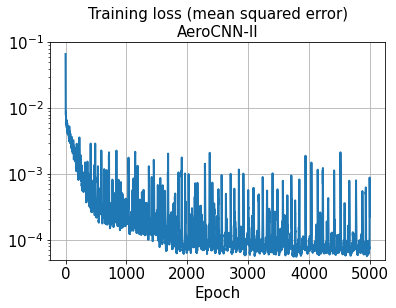

In [39]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

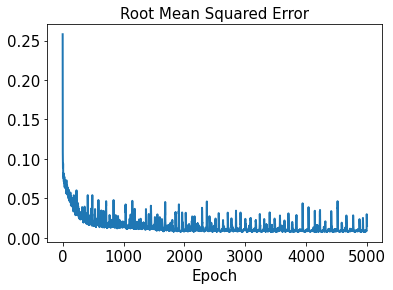

In [40]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

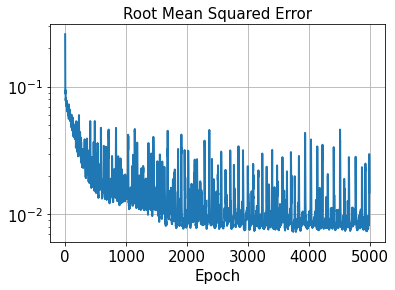

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [42]:
test_results = model.evaluate(x_train)

47/47 [==============================] - 0s 2ms/step - loss: 2.5122e-06 - rmse: 0.0000e+00


In [43]:
decoded_train = model.predict(x_train)

47/47 [==============================] - 0s 5ms/step


In [44]:
x_train.shape

(1488, 100, 100, 1)

In [45]:
decoded_test = model.predict(x_test)

20/20 [==============================] - 0s 5ms/step


In [46]:
error_train_abs = np.abs(decoded_train - y_train)

In [47]:
error_test_abs = np.abs(decoded_test - y_test)

In [48]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [49]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [50]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [51]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [52]:
decoded_train.shape

(1488, 2, 1)

In [53]:
os.chdir("D:\\TrainedModels\\20221005")
model.save('AeroCNN-II_25kernel_3CNNlayer.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [54]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.02353880719665615


In [55]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.19539791074324667


In [56]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.02161679498619804


In [57]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.05394879229509046


In [58]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.19086531087102268


In [59]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.284767415106112


In [60]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.010013669911698561, 0.011447602644457709, 0.013513582747932384, 0.1280172999777919, 0.15321943217943076, 0.03229191882229137, 0.00316625277195063, 0.008509442871869524, 0.00678726032300447, 0.01610804464029669, 0.005548499653724133, 0.004327512106955172, 0.02268868091852391, 0.006696325525825078, 0.020017648216961066, 0.006428027464067234, 0.004274483254058531, 0.015763945434542997, 0.008285299996343882, 0.0869105681482092, 0.02429603339543682, 0.024904494371323686, 0.007442793800121236, 0.024705001439018652, 0.0036647444539163955, 0.024459422927678203, 0.01563197719162841, 0.014332192853202988, 0.012080891537056219, 0.0245252045598849, 0.011009788860185221, 0.020857479626056327, 0.009601068887550992, 0.019934105721459455, 0.012793706852220374, 0.029820981661497416, 0.12942872965193572, 0.1044263222856083, 0.022714543643253756, 0.018605049278556003, 0.014020735242016762, 0.005837363757301757, 0.024264970250088874, 0.01768767382116375, 0.014424776236682405, 0.05597793112747392, 0.024

In [61]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.03812574588755272, 0.02303788624494117, 0.036768718938626446, 0.07676264808609948, 0.030285807182883758, 0.3598430052463733, 0.15276395046501112, 0.045538718233534274, 0.08255375174917574, 0.01913901018315771, 0.3299719108205385, 0.05588247267878391, 0.07499422455502544, 0.44074815967742675, 0.22223698243717152, 0.14399536290840623, 0.050665571124746824, 0.06393752992415012, 0.16209960673714718, 0.0447382683630277, 2.1117984139565813, 0.6118585265414249, 0.08672241606207094, 0.06502320152076635, 0.04476379423195069, 0.05066314445313977, 0.025161798368279416, 0.0323314268797935, 0.04199896689182166, 0.03923169045796802, 0.3295956539834231, 0.3944742928682688, 0.027151731920316707, 0.06751179730946046, 0.022878432914966995, 0.1121807076565426, 0.3992550717557909, 0.8500681958465239, 0.3903703871610541, 0.20064472861231475, 0.14583301601934442, 0.1208687204785551, 0.3867528234002132, 0.13553881940697882, 0.07034812409922156, 0.36563907063173956, 0.028975087563921652, 0.0140252457212746

In [62]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.008250103548071402, 0.0006430697189800405, 0.007349733468158587, 0.12218974208397827, 0.15315832500281337, 0.028882751388778712, 0.002925877644060072, 0.0067479368564619035, 0.005559705157963386, 0.014092542170504058, 0.004305409340989189, 0.0030838681055990113, 0.02272302098655586, 0.005154877820777378, 0.015021689122284583, 0.001439650828784847, 0.003623846018229723, 0.015463587488175107, 0.007811706993804596, 0.0869707922490245, 0.0074901656965616825, 0.025011918080991187, 0.006526685886406787, 0.0246028234781419, 0.0001473069121296051, 0.02444248180830283, 0.013786978707393047, 0.006981000582099729, 0.0010644390618014842, 0.023703860916385128, 0.00864772223748377, 0.019858571635467583, 0.009111956916092848, 0.005247950114150794, 0.012222425296176582, 0.0242169965006824, 0.12692021414093424, 0.07594061010856713, 0.016136834044908368, 0.018468059012807958, 0.011831066559344116, 0.005807656108546508, 0.009564196509686707, 0.017282131187503928, 0.00976991471242865, 0.055016695692180

In [63]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.1284332276111474, 0.24723158705222534, 0.17051541772265086, 0.20736948814103828, 0.15755092472534407, 0.30345615529152725, 0.03726000860591729, 0.18768535322617114, 0.14254341195227577, 0.2573618201885172, 0.09542454405501709, 0.06843280549018108, 0.0027246166570180225, 0.05955155219943519, 0.1589802335753838, 0.055866517422443085, 0.05124845167557644, 0.0810793958900575, 0.06780174406253615, 0.06804886451934981, 0.12369671244338853, 0.01783277012075496, 0.06893030106700275, 0.06628131940690268, 0.11108908120666365, 0.03521782464914752, 0.16566455172117658, 0.22324256329973297, 0.1601102917796587, 0.07546986215384151, 0.06107453814598963, 0.04913156175381232, 0.015927479278948126, 0.11390697669023908, 0.04880300665408568, 0.3291672514238213, 0.273836904149585, 0.44735855813359077, 0.33523767585634756, 0.07212861558244123, 0.22640921787103457, 0.011125576282505524, 0.21769039701192083, 0.02425045698153146, 0.04027570638329945, 0.06425707425410081, 0.02291089521091034, 0.0087376642741

In [64]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.273836904149585

In [65]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.038402010902805726, 0.021214740861524917, 0.028403496477502902, 0.07673146112108263, 0.01895072063773496, 0.3641668459748883, 0.1510511891421148, 0.04555914447376535, 0.08238341943108254, 0.01908266423330245, 0.334987583711134, 0.05563768960871665, 0.07740236351722524, 0.4327939539698477, 0.22393655855138248, 0.15320036505742926, 0.05053041576233676, 0.06225130626856267, 0.16219574118768595, 0.044834796458479834, 3.0274310038931653, 0.6133004125870092, 0.08673840562365938, 0.06503691788074069, 0.04456949646170216, 0.04997886852810795, 0.00290616904894861, 0.024233533344163727, 0.03801547009323142, 0.009537716210813224, 0.3322087093580748, 0.4089968461284431, 0.027499714700348187, 0.06717900455511322, 0.02175476611263075, 0.11226846062272924, 0.3995437833866727, 0.8648433317595293, 0.39030087174506156, 0.20065240675417811, 0.14588370798196335, 0.11792924687690576, 0.3892449320816324, 0.1345110079914859, 0.06558232126308056, 0.3683232834463536, 0.01997829214354372, 0.01087433707008195

In [66]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.0323949054900497, 0.058154337354928934, 0.31343781177665825, 0.08725934898791082, 0.23322613776368614, 0.21743547183510942, 0.49003154622228445, 0.023083213635317495, 0.15246997791631978, 0.027998126135105834, 0.0640937144729553, 0.06013306997565634, 0.030522869857200704, 0.5110894581769321, 0.20746805502718513, 0.0540515100884397, 0.12361907418152293, 0.4376499270628321, 0.09141746395696503, 0.018294266239966595, 0.29628462909237047, 0.29564009337696423, 0.07561323641639979, 0.044611961442929844, 0.17664298318043278, 0.34993716574575534, 0.9449923900865537, 0.6371666390529535, 0.3407874849381727, 0.3840867726666897, 0.25995431541431285, 0.3026321486030073, 0.01982732583335788, 0.07977769813061297, 0.11065697798401165, 0.059523719355519054, 0.3645302938373843, 0.3250593689675691, 0.4176791015589676, 0.1931802426575324, 0.06854366887695877, 0.5678055798780725, 0.049279822453747714, 0.15410799788340646, 0.11838443092161234, 0.33320912175356354, 0.06866239171835288, 0.02745540968295899

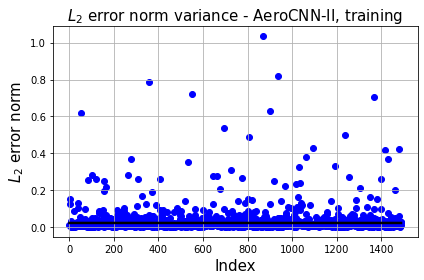

In [67]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

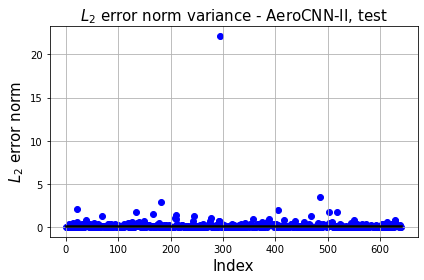

In [68]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

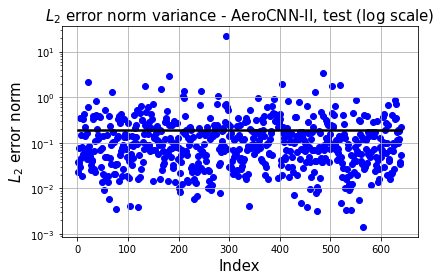

In [69]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

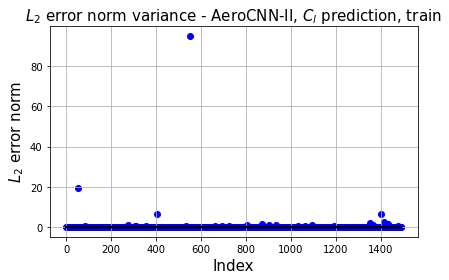

In [70]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

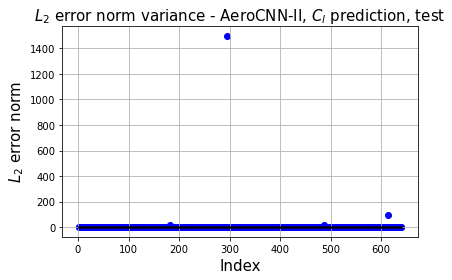

In [71]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

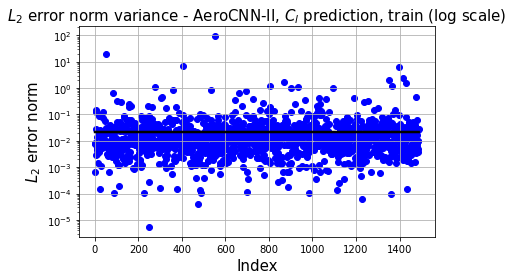

In [72]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

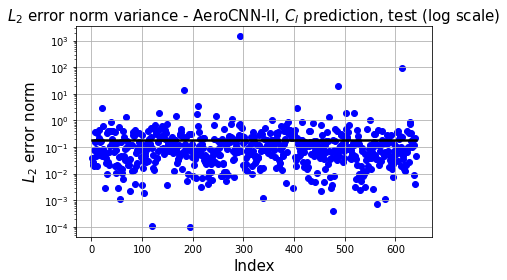

In [73]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

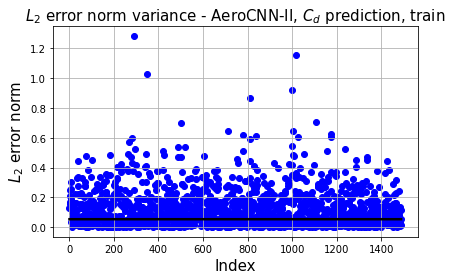

In [74]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

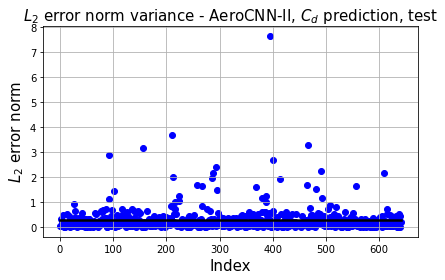

In [75]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

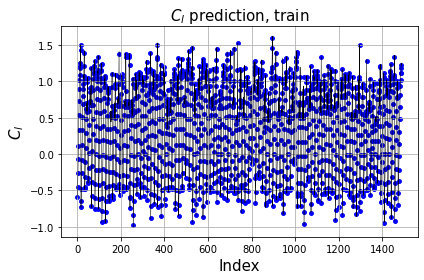

In [76]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

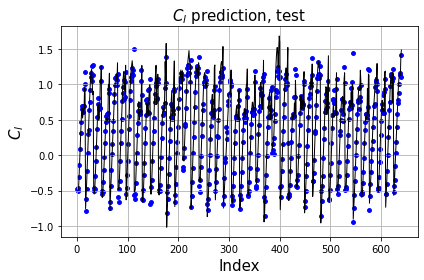

In [77]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

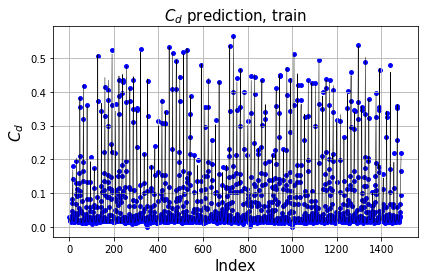

In [78]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

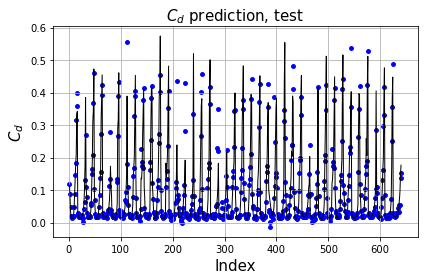

In [79]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

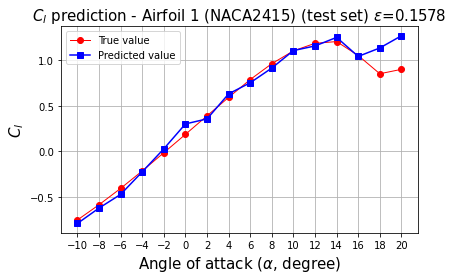

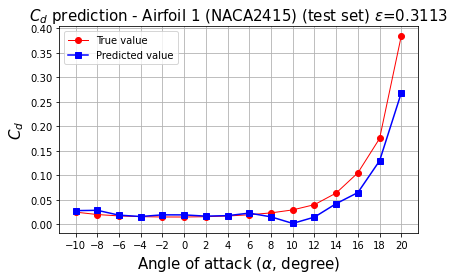

In [102]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [106]:
np.sqrt(np.sum((airfoiltest37_predict[0,0,:] - airfoiltest37_cl[0,:])**2) / np.sum(airfoiltest37_cl[0,:]**2))

0.13879795970485131

In [107]:
airfoiltest37_cl[0,:]

array([-0.67788063])

In [108]:
airfoiltest37_predict[0,0,:]

array([-0.7719691], dtype=float32)

In [109]:
np.sqrt(((-0.7719691+0.67788063)**2)/((-0.67788063)**2))

0.13879799161690162

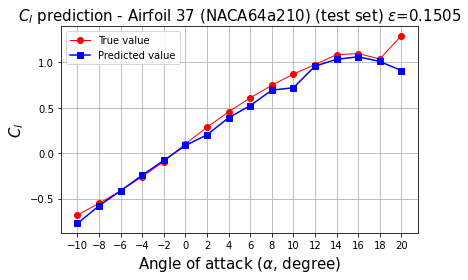

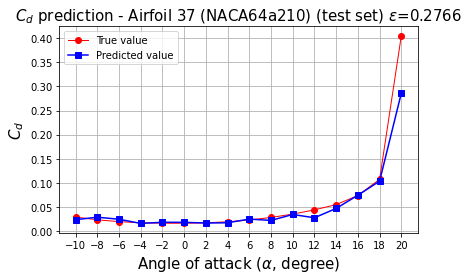

In [104]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

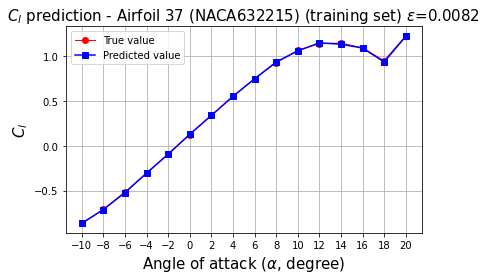

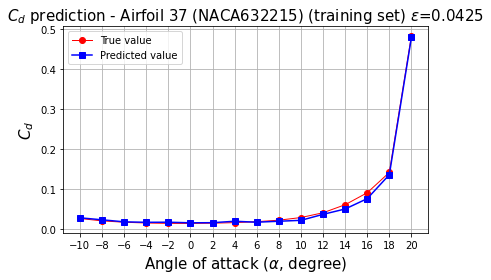

In [100]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

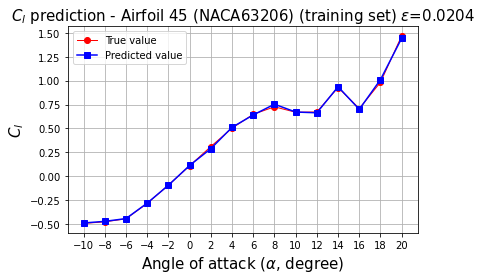

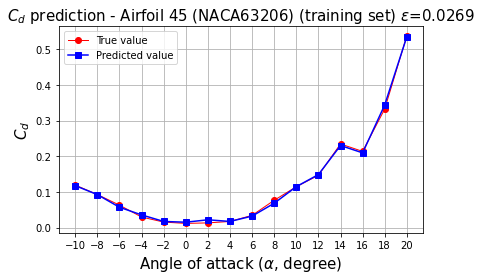

In [99]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

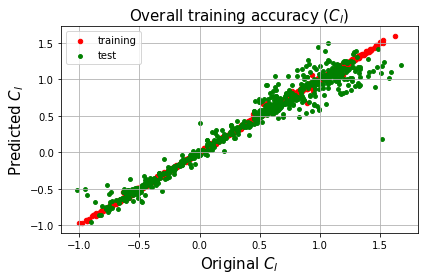

In [85]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

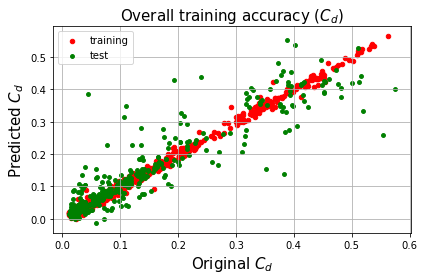

In [86]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

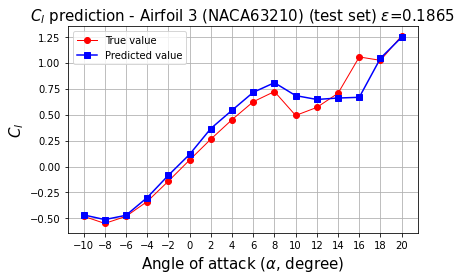

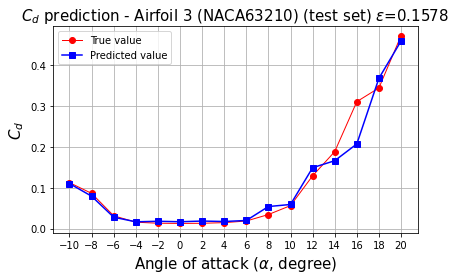

In [96]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

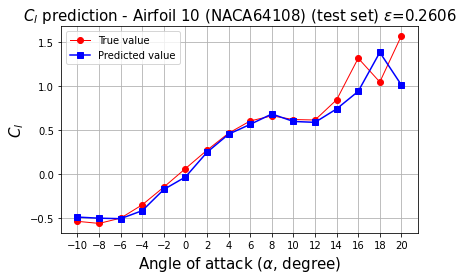

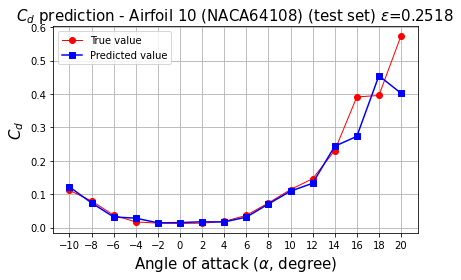

In [97]:
airfoiltest11_predict = decoded_test[16*10:16*11]

airfoiltest11_cl=y_test[16*10:16*11,0,:]
airfoiltest11_cd=y_test[16*10:16*11,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()